## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [4]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [5]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

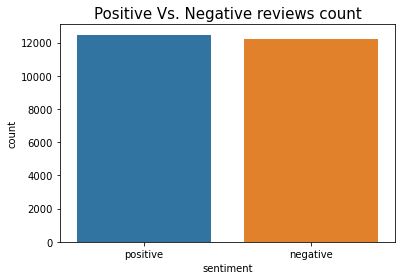

In [7]:
plt.figure(figsize = None)
sns.countplot(x= "sentiment", data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [8]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df.sentiment == 'positive']
df_minority = df[df.sentiment == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [9]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
print(df_upsampled[df_upsampled.sentiment == 'negative'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [10]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print(df_upsampled[df_upsampled.sentiment == 'positive'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [11]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled.sentiment == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled.sentiment == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled.sentiment == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled.sentiment == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train["review"], positive_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train["sentiment"], positive_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test["review"], positive_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test["sentiment"], positive_data_points_test["sentiment"]])


In [12]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [13]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [50]:
# TASK CELL
import re
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
def lemmatizing(review_cleaned):
    lemmatizer = WordNetLemmatizer()
    l_clean = []
    for w in review_cleaned:
        l_clean.append(lemmatizer.lemmatize(w))
    return l_clean

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review_cleaned = re.sub(r"http\S+", "", review) #remove links
    
    review_cleaned = review_cleaned.lower()
    review_cleaned = word_tokenize(review_cleaned)

    review_cleaned = remove_punctuation(review_cleaned) #remove punctuations
    review_cleaned = remove_stopwords(review_cleaned) #remove stopwords
    
    review_cleaned = lemmatizing(review_cleaned)
    
    return " ".join(review_cleaned)


## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [15]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0
    t_word = (word, label)
    if t_word in frequency:
        n = frequency[t_word]
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [16]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [17]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [18]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'STRANGER THAN FICTION angered me so much, I signed up on IMDb just to write this review. STRANGER THAN FICTION is a surprisingly complex, touching and thought-provoking movie until the very end. Once you suspend multiple lapses of logic (why didn\'t Will Ferrell hear Emma Thompson\'s voice 10 years ago when she fist started writing her book? "The phone rang. The phone rang again." How could she not know it\'s him calling? etc.), the movie challenges one\'s thoughts about mortality, fate, and sacrifice.<br /><br />The brief history of literary themes provided by Dustin Hoffman should especially entertain former English majors. And Maggie Gyllenhaal is always a pleasure, even though Will Ferrell might just as easily be an ax murderer as a bumbling soul. Her quick trust of him is a mighty big leap of faith.<br /><br />Ah, but the ending. Until the very end, I would have given 9 out of 10 stars to this movie. The movie as a metaphor for life\'s journey, as a tribute to the notion of \'wri

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [19]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

stranger fiction angered much signed imdb write review stranger fiction surprisingly complex touching thoughtprovoking movie end suspend multiple lapses logic nt ferrell hear emma thompson voice 10 years ago fist started writing book phone rang phone rang could know calling etc movie challenges one thoughts mortality fate sacrifice br br brief history literary themes provided dustin hoffman especially entertain former english majors maggie gyllenhaal always pleasure even though ferrell might easily ax murderer bumbling soul quick trust mighty big leap faith br br ah ending end would given 9 10 stars movie movie metaphor life journey tribute notion writing true reminder great literature either comedy tragedy outstanding entire movie leads viewer understand accept moment ferrell fate matter endearing character may become know full well accept ending last act occurs screen goes white credits roll profound powerful end almost perfect film end would debated weeks br br credits rolled say nt

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [20]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    output_occurrence = {}
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review).split()
        for word in split_review:
            temp_tuple = (word, label)
            if temp_tuple in output_occurrence:
                output_occurrence[temp_tuple] += 1
            else:
                output_occurrence[temp_tuple] = 1
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [21]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
sorted(review_counter(result,reviews, ys))

[('bored', 1),
 ('complete', 1),
 ('enjoyed', 0),
 ('fantastic', 0),
 ('fullest', 0),
 ('got', 1),
 ('money', 1),
 ('movie', 0),
 ('moview', 1),
 ('throught', 1),
 ('time', 1),
 ('waste', 1),
 ('watch', 1)]

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [22]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [23]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('stranger', 1): 47,
 ('fiction', 1): 146,
 ('angered', 1): 8,
 ('much', 1): 3929,
 ('signed', 1): 25,
 ('imdb', 1): 341,
 ('write', 1): 326,
 ('review', 1): 422,
 ('surprisingly', 1): 113,
 ('complex', 1): 105,
 ('touching', 1): 60,
 ('thoughtprovoking', 1): 20,
 ('movie', 1): 19812,
 ('end', 1): 2189,
 ('suspend', 1): 32,
 ('multiple', 1): 70,
 ('lapses', 1): 11,
 ('logic', 1): 120,
 ('nt', 1): 15758,
 ('ferrell', 1): 23,
 ('hear', 1): 302,
 ('emma', 1): 21,
 ('thompson', 1): 29,
 ('voice', 1): 343,
 ('10', 1): 849,
 ('years', 1): 1467,
 ('ago', 1): 416,
 ('fist', 1): 19,
 ('started', 1): 399,
 ('writing', 1): 617,
 ('book', 1): 1018,
 ('phone', 1): 180,
 ('rang', 1): 17,
 ('could', 1): 4525,
 ('know', 1): 2660,
 ('calling', 1): 83,
 ('etc', 1): 525,
 ('challenges', 1): 10,
 ('one', 1): 10184,
 ('thoughts', 1): 59,
 ('mortality', 1): 2,
 ('fate', 1): 84,
 ('sacrifice', 1): 39,
 ('br', 1): 41428,
 ('brief', 1): 149,
 ('history', 1): 434,
 ('literary', 1): 32,
 ('themes', 1): 119,
 ('

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [24]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for t in freqs:
        if t[0] not in vocab:
            vocab.append(t[0])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)
    output_count = train_y.value_counts()
    
    # Calculate D_pos, the number of positive documents 
    pos_num_docs = output_count.get(key = 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = output_count.get(key = 1)

    # Calculate logprior
    logprior = math.log(pos_num_docs / neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,0)
        freq_neg = find_occurrence(freqs,word,1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = freq_pos + 1 / (num_pos + num_neg)
        p_w_neg = freq_neg + 1 / (num_pos + num_neg)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = math.log(p_w_neg/p_w_pos)


    return logprior, loglikelihood

In [25]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
80847


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [26]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0
        
    return total_prob

In [27]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [47]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  
    total_reviews = test_x.shape[0]
    
    y_pred = []
    y_pred_i = 0
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood):
            # the predicted class is 1
            y_pred_i = 1
        else:
            # otherwise the predicted class is 0
            y_pred_i = 0

        # append the predicted class to the list y_hats
        y_pred.append(y_pred_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = 0

    for i in range(total_reviews):
        if y_pred[i] != test_y.iloc[i]:
            error += 1

    accuracy = ( total_reviews - error ) / total_reviews

    return accuracy, y_pred

In [29]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [30]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [35]:
df_sampled = df_upsampled.sample(frac=1, random_state=0)
## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled.sentiment == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled.sentiment == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled.sentiment == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled.sentiment == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train["review"], positive_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train["sentiment"], positive_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test["review"], positive_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test["sentiment"], positive_data_points_test["sentiment"]])

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)
freqs = review_counter({}, X_train, y_train)
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)



In [48]:
accuracy_train, y_pred_train = test_naive_bayes(X_train, y_train, logprior, loglikelihood)
print("Train Accuracy: " + str(accuracy_train))
accuracy_test, y_pred_test = test_naive_bayes(X_test, y_test, logprior, loglikelihood)
print("Test Accuracy: " + str(accuracy_test))

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
matrix_train = confusion_matrix(y_train, y_pred_train)
print(matrix_train)
matrix_test = confusion_matrix(y_test, y_pred_test)
print(matrix_test)


#4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.
# Due to sample data some words have multiple meaning and in the training data these words have 
# high probability of negative 

Train Accuracy: 0.9819
Test Accuracy: 0.8516572352465642
[[9772  228]
 [ 134 9866]]
[[2132  342]
 [ 392 2082]]


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)
Answer: While working on a classification problem (Natural Language Processing) such as positive negative reviews here, Naive Bayes algorithm gives suspicious predictions sometimes.The cause of such a problem is a zero probability problem for the test data. Therefore, the most reliable solution is to overcome this problem is Laplace smoothing which is a smoothing technique that helps tackle the problem of zero probability in the Naïve Bayes machine learning algorithm. Here, in out dataset, given reviews (text) has to be classified to be either positive or negative. We build a likelihood table using the present training set. However, when likelihood values are used for predicting the test dataset some words occur only in the test dataset but not in the training set.

Let us take one simple test review for example;

review= "w1w2w"

This sample have three words, where we assume w1 and w2 are present in the training data but not w. Therefore, we have the likelihood for these two words. Now, for predicting whether the review is positive or negative, we compare P(positive/review) and P(negative/review) and choose the maximum probability out of the two to our prediction for review.

We use the Bayes theorem to calculate these probabilities. While calculating these probabilities, we don’t involve the evidence for our calculations since evidence remains constant for all the classes. So, now probability equation becomes,

P(positive/review) = KP(w1/positive)P(w2/positive)P(w/positive)P(positive)

Similarly,

P(negative/review) = KP(w1/negative)P(w2/negative)P(w/negative)P(negative)

Here k is the proportionality constant.

In the likelihood table, the value of P(w1/positive), P(w2/positive) and P(positive) are present but P(w/positive) is not present since w is not present in our training data. As we have no value for this probability. Now, we are unable to be sure about the prediction and our model performed poorly.

2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)
Answer : Logarithmic values are computed instead of only probaility values in the Naive Bayes algorithm is because of log increases or decreases monotonically which means that it will not affect the order of probabilities. Smaller probabilities will still stay smaller after the log has been applied to them and vice versa. Therefore, let’s say that a test word "is" has a smaller probability than the test word "happy", so after passing these through log would although increase their magnitude but "is" would still have a smaller probability than "happy". Thus, without affecting the predictions of our trained model, we can effectively avoid the common pitfall of underflow error.